In [1]:
import camb
ellmax = 6000
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.36, ombh2=0.02237, omch2=0.12, mnu=0.06, omk=0, tau=0.0544)
pars.InitPower.set_params(As=2.1e-9, ns=0.9649, r=0)
pars.set_for_lmax(ellmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
all_cls_th = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total']

In [27]:
Tcmb = 2.726e6

In [2]:
path = "/pscratch/sd/c/chervias/Cosmic_birefringence/Forecast_anisotropic_LAT"

In [31]:
import numpy as np
import healpy as hp
import os
import sys
import matplotlib.pyplot as plt
import curvedsky as cs

In [4]:
idx = 0

In [14]:
Emap,Bmap = hp.read_map(os.path.join(path,'CMB_hilc_LAT_Set1_d10s5_seed0000_nside2048_isonoise.fits'), field=(0,1))

In [24]:
Nemap,Nbmap = hp.read_map(os.path.join(path,'Noise_hilc_LAT_Set1_seed0000_nside2048_isonoise.fits'), field=(0,1))

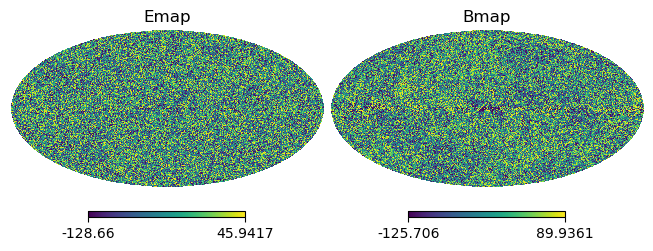

In [16]:
hp.mollview(Emap, title='Emap', sub=121,norm='hist')
hp.mollview(Bmap, title='Bmap', sub=122,norm='hist')    

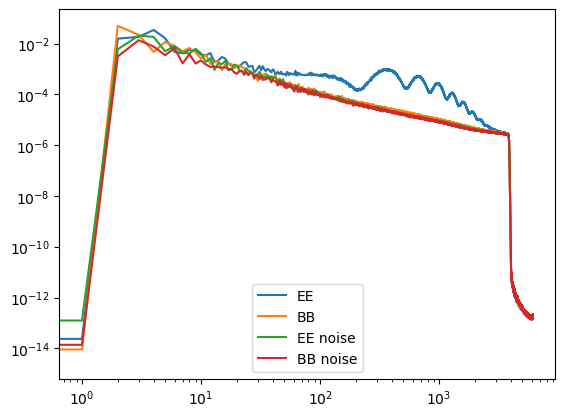

In [25]:
plt.loglog(hp.anafast(Emap), label='EE')
plt.loglog(hp.anafast(Bmap), label='BB')
plt.loglog(hp.anafast(Nemap), label='EE noise')
plt.loglog(hp.anafast(Nbmap), label='BB noise')
plt.legend()

In [26]:
ncle = hp.anafast(Nemap)
nclb = hp.anafast(Nbmap)

In [28]:
cl_len = all_cls_th.T/Tcmb**2

In [29]:
nside = 2048
lmax  = 2048 
rlmin = 50
rlmax = 2048 

In [33]:
lcl = cl_len.copy()
nl  = np.zeros((4,lmax+1))
nl[1,:] = ncle[:lmax+1]/Tcmb**2
nl[2,:] = nclb[:lmax+1]/Tcmb**2
ocl = lcl[:,:lmax+1] + nl

Al = np.zeros((2,lmax+1))
Al[0,:] = cs.norm_quad.qeb('rot',lmax,rlmin,rlmax,lcl[1,:rlmax+1],ocl[1,:rlmax+1],ocl[2,:rlmax+1])[0]
Al[1,:] = cs.norm_quad.qtb('rot',lmax,rlmin,rlmax,lcl[3,:rlmax+1],ocl[0,:rlmax+1],ocl[2,:rlmax+1])[0]

In [34]:
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [48]:
Ealm = cs.utils.hp_map2alm(nside,lmax,lmax,Emap/Tcmb)

In [49]:
Balm = cs.utils.hp_map2alm(nside,lmax,lmax,Bmap/Tcmb)

In [50]:
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

In [51]:
Ealm = Ealm[:rlmax+1,:rlmax+1]
Balm = Balm[:rlmax+1,:rlmax+1]

In [52]:
unnorm_aalm = cs.rec_rot.qeb(lmax,rlmin,rlmax,lcl[1,:rlmax+1],Ealm,Balm)

 compute polarization rotation


In [53]:
norm_aalm = unnorm_aalm[:lmax+1,:lmax+1] * Al[0][:,None]

In [54]:
input_alpha = hp.read_map(os.path.join(path,'alpha_realization_0000.fits'))

In [55]:
input_aalm = cs.utils.hp_map2alm(nside,lmax,lmax,input_alpha)

In [56]:
cl_recon = cs.utils.alm2cl(lmax,norm_aalm)
cl_input = cs.utils.alm2cl(lmax,input_aalm)
cl_r_i = cs.utils.alm2cl(lmax,norm_aalm,input_aalm)

(2, 500)

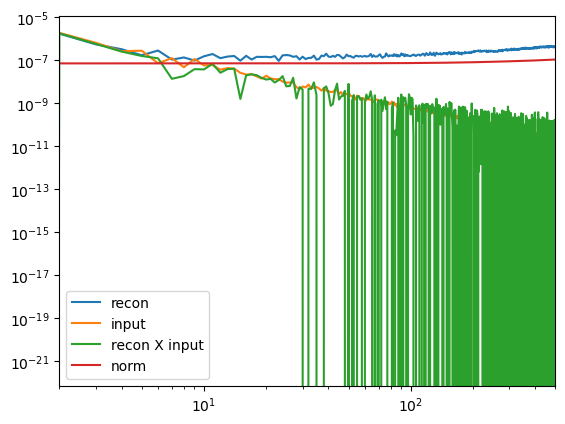

In [59]:
plt.loglog(cl_recon,label='recon')
plt.loglog(cl_input,label='input')
plt.loglog(cl_r_i,label='recon X input')
plt.loglog(Al[0],label='norm')
plt.legend()
plt.xlim(2,500)